In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Убедимся, что TensorFlow использует GPU (если доступен)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU доступен: {physical_devices}")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU не найден, используется CPU.")

TensorFlow version: 2.18.0
GPU не найден, используется CPU.


In [7]:
import tensorflow as tf
import os

def create_denoising_dataset_v2(noisy_folders, clean_folders, image_size=(128, 128), batch_size=20):
    """
    Создает tf.data.Dataset для задачи денойзинга изображений, где каждая папка с зашумленными версиями
    содержит модификации одного изображения, находящегося в соответствующей папке с чистым изображением.
    
    Аргументы:
    - noisy_folders: список путей к папкам с зашумленными версиями изображений.
    - clean_folders: список путей к папкам с чистыми изображениями.
    - image_size: кортеж с размером изображений (по умолчанию (128, 128)).
    - batch_size: размер батча (по умолчанию 32).
    
    Возвращает:
    - tf.data.Dataset, где входы — зашумленные изображения, а выходы — чистые изображения.
    """
    def load_image(image_path):
        """Загружает и нормализует изображение."""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=1)  # Градации серого
        image = tf.image.resize(image, image_size)  # Изменение размера
        image = tf.cast(image, tf.float32) / 255.0  # Нормализация в диапазон [0, 1]
        return image

    noisy_image_paths = []
    clean_image_paths = []

    # Составляем списки путей для зашумленных и чистых изображений
    for noisy_folder, clean_folder in zip(noisy_folders, clean_folders):
        noisy_paths = tf.io.gfile.glob(os.path.join(noisy_folder, "*.png"))
        clean_image_path = tf.io.gfile.glob(os.path.join(clean_folder, "*.png"))[0]  # Чистое изображение одно
        noisy_image_paths.extend(noisy_paths)
        clean_image_paths.extend([clean_image_path] * len(noisy_paths))  # Повторяем путь чистого изображения

    # Убеждаемся, что количество зашумленных и чистых изображений совпадает
    assert len(noisy_image_paths) == len(clean_image_paths), "Количество зашумленных и чистых изображений должно совпадать!"

    # Создаем датасеты
    noisy_dataset = tf.data.Dataset.from_tensor_slices(noisy_image_paths).map(
        lambda path: load_image(path),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    clean_dataset = tf.data.Dataset.from_tensor_slices(clean_image_paths).map(
        lambda path: load_image(path),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Объединяем зашумленные изображения (вход) с чистыми (выход)
    dataset = tf.data.Dataset.zip((noisy_dataset, clean_dataset))

    # Перемешивание и разбиение на батчи
    dataset = dataset.shuffle(buffer_size=len(noisy_image_paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [9]:
noisy_folders = [
    "DATASETS/DATASET_2/fig1",  # Папка с зашумленными версиями первого изображения
    "DATASETS/DATASET_2/fig2",  # Папка с зашумленными версиями второго изображения
    "DATASETS/DATASET_2/fig3",
    "DATASETS/DATASET_2/fig4",
    "DATASETS/DATASET_2/fig5"
]

clean_folders = [
    "DATASETS/DATASET_2/truefig1",  # Папка с первым чистым изображением
    "DATASETS/DATASET_2/truefig2",  # Папка со вторым чистым изображением
    "DATASETS/DATASET_2/truefig3",
    "DATASETS/DATASET_2/truefig4",  
    "DATASETS/DATASET_2/truefig5"   
]

### РАЗМЕРНОСТЬ ИЗОБРАЖЕНИЯ И БАТЧА ###

BUTCH_SIZE = 1 # Butch size
IMG_SIZE = (128, 128)  # Img Size


dataset = create_denoising_dataset_v2(noisy_folders, clean_folders, image_size=IMG_SIZE, batch_size=BUTCH_SIZE)

# Проверка
print(dataset.__len__())
for noisy_images, clean_images in dataset.take(1):
    print("Размер входного батча:", noisy_images.shape)
    print("Размер выходного батча:", clean_images.shape)


tf.Tensor(505, shape=(), dtype=int64)
Размер входного батча: (1, 128, 128, 1)
Размер выходного батча: (1, 128, 128, 1)


2024-11-19 18:04:21.573507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
import matplotlib.pyplot as plt

def display_noisy_clean_grid(noisy_images, clean_images, title="Noisy vs Clean", rows=5):
    """
    Отображает зашумленные и чистые изображения в виде таблицы.
    Каждая строка содержит парные изображения: зашумленное и чистое.
    
    Аргументы:
    - noisy_images: список или тензор зашумленных изображений (N, H, W, C).
    - clean_images: список или тензор чистых изображений (N, H, W, C).
    - title: заголовок таблицы (по умолчанию "Noisy vs Clean").
    - rows: количество строк в таблице (по умолчанию 5).
    """
    # Если батч содержит одно изображение, добавляем ось для совместимости
    if len(noisy_images.shape) == 3:  # (H, W, C)
        noisy_images = noisy_images[None, ...]  # Добавляем ось (1, H, W, C)
    if len(clean_images.shape) == 3:  # (H, W, C)
        clean_images = clean_images[None, ...]

    cols = 2  # Каждый пример содержит два изображения: зашумленное и чистое
    total_images = min(len(noisy_images), len(clean_images), rows)
    
    # Преобразуем тензоры в numpy (если нужно)
    if tf.is_tensor(noisy_images):
        noisy_images = noisy_images.numpy()
    if tf.is_tensor(clean_images):
        clean_images = clean_images.numpy()

    # Создаем фигуру
    fig, axes = plt.subplots(total_images, cols, figsize=(5, 3 * total_images))
    fig.suptitle(title, fontsize=16)

    # Обрабатываем случай с единственной строкой (total_images = 1)
    if total_images == 1:
        axes = [axes]  # Преобразуем в список для унифицированной обработки

    # Отображаем изображения
    for i in range(total_images):
        # Зашумленное изображение
        axes[i][0].imshow(noisy_images[i], cmap='gray')
        axes[i][0].set_title("Noisy")
        axes[i][0].axis("off")

        # Чистое изображение
        axes[i][1].imshow(clean_images[i], cmap='gray')
        axes[i][1].set_title("Clean")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



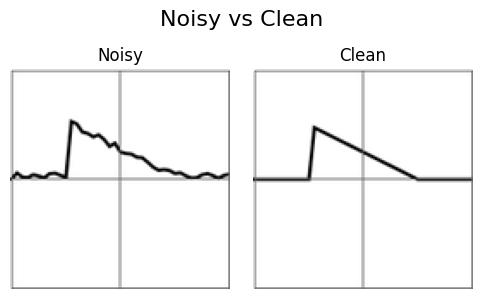

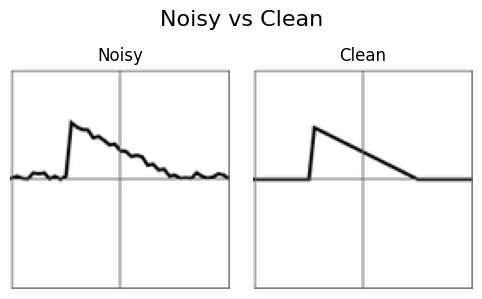

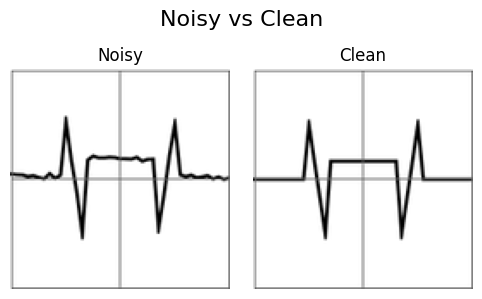

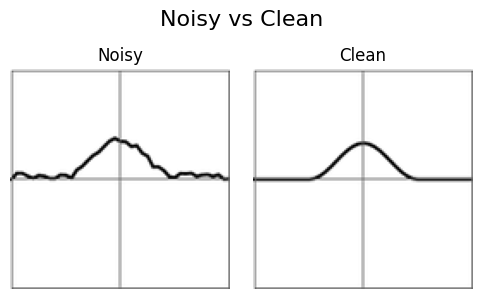

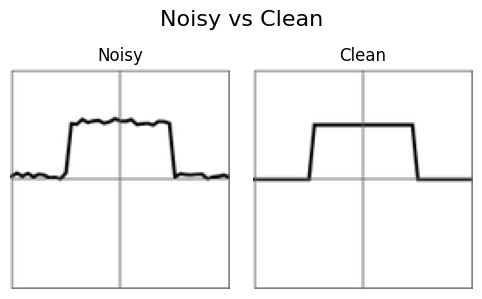

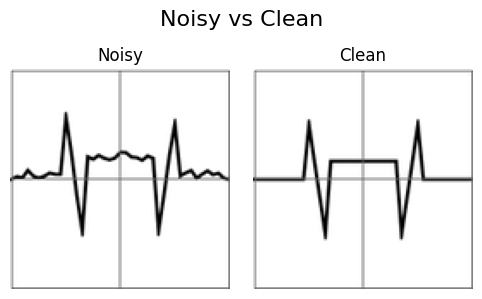

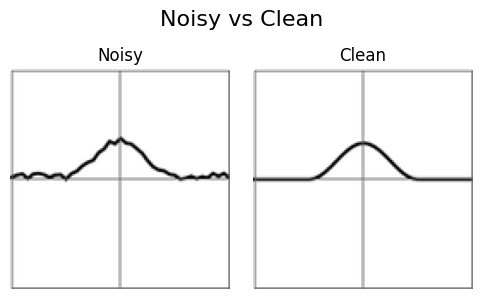

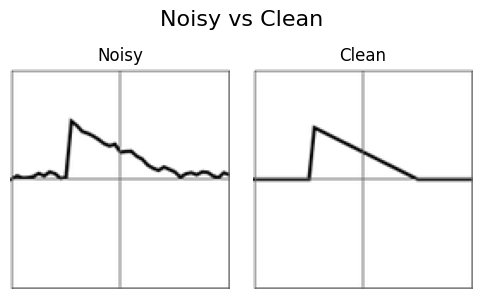

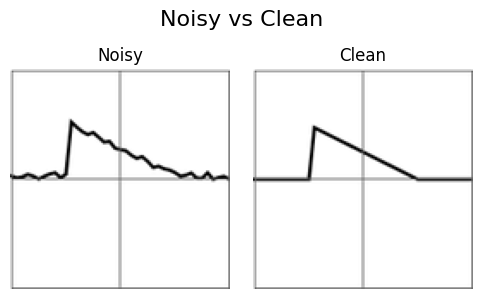

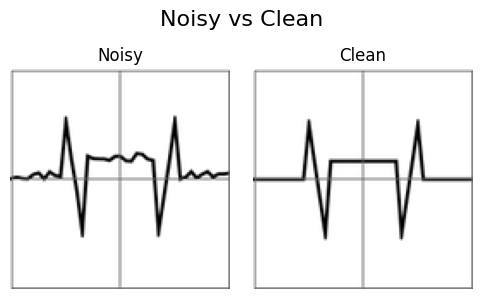

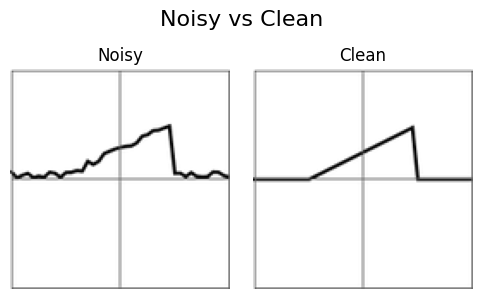

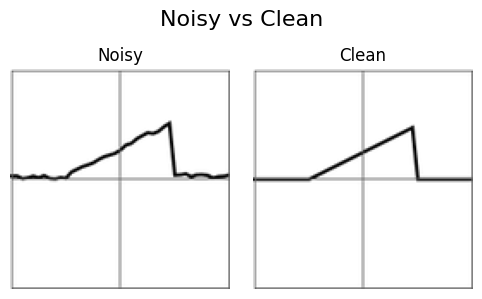

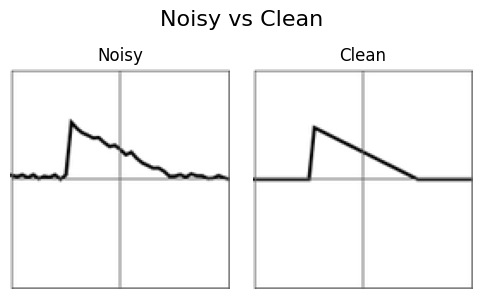

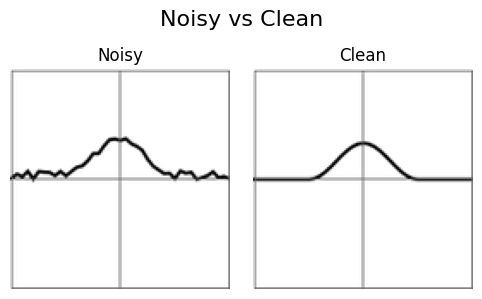

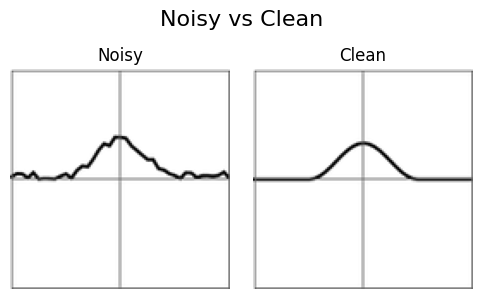

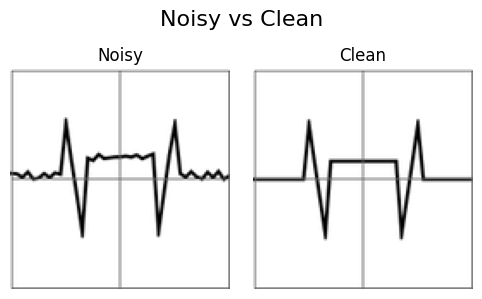

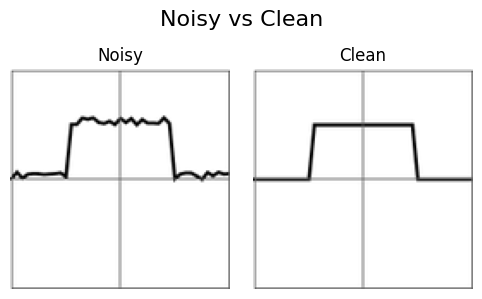

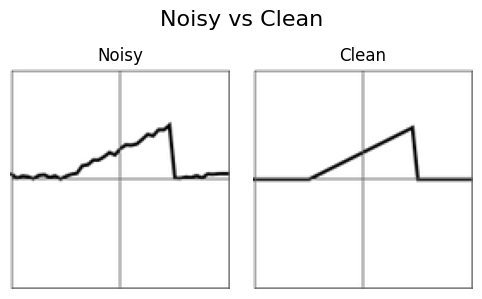

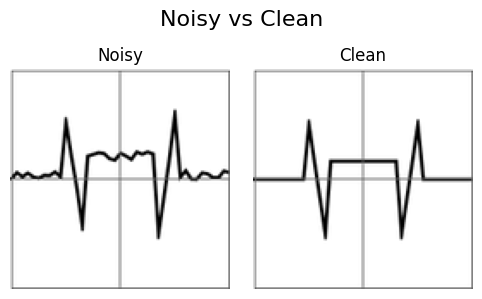

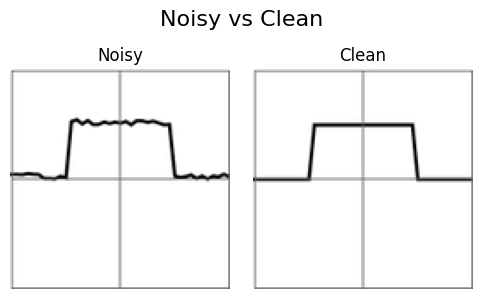

In [24]:
# Взять один батч из датасета
for noisy_images, clean_images in dataset.take(20):
    # Ограничиваем выборку первыми 5 парами
    noisy_images_5 = noisy_images[:5]
    clean_images_5 = clean_images[:5]

    # Отображаем пары изображений
    display_noisy_clean_grid(noisy_images_5, clean_images_5, title="Noisy vs Clean")


In [13]:
import tensorflow as tf

# Задаем входную форму изображения
BUTCH_SIZE
input_shape = (IMG_SIZE[0], IMG_SIZE[1], BUTCH_SIZE)  # Например, 128x128 RGB изображения

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

# Модель для денойзинга изображений
model = Sequential([
    # Encoder: Сверточные слои для извлечения признаков
    Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    
    Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    
    # Decoder: Декодирующие слои для восстановления изображений
    Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    UpSampling2D(size=2),
    
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    UpSampling2D(size=2),
    
    # Выходной слой с одним каналом (черно-белое изображение)
    Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()



/home/gercklim/WORK_DIRECTORY/7_СЕМ/Курсовая_работа_7_сем/NW_for_Transfer_Equation/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,985 (1.14 MB)

 Trainable params: 297,217 (1.13 MB)

 Non-trainable params: 768 (3.00 KB)

In [14]:
# Предположим, что dataset уже создан, например, как выше:
# dataset содержит пары (noisy_images, clean_images)

# Разделим датасет на обучающую и валидационную выборки
train_dataset = dataset.take(80)  # 80% данных для обучения
val_dataset = dataset.skip(80).take(20)  # 20% данных для валидации

# Добавляем батчирование и опциональное перемешивание
train_dataset = train_dataset.shuffle(buffer_size=100).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


In [15]:
for noisy_images, clean_images in train_dataset.take(1):
    print("Noisy shape:", noisy_images.shape)
    print("Clean shape:", clean_images.shape)


Noisy shape: (1, 128, 128, 1)
Clean shape: (1, 128, 128, 1)


In [16]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    verbose=2
)


Epoch 1/100


2024-11-19 18:06:48.002714: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


80/80 - 4s - 46ms/step - loss: 0.0615 - mae: 0.1387 - val_loss: 0.0207 - val_mae: 0.0462
Epoch 2/100
80/80 - 2s - 24ms/step - loss: 0.0204 - mae: 0.0671 - val_loss: 0.0251 - val_mae: 0.0781
Epoch 3/100
80/80 - 2s - 24ms/step - loss: 0.0132 - mae: 0.0459 - val_loss: 0.8356 - val_mae: 0.8761
Epoch 4/100
80/80 - 2s - 24ms/step - loss: 0.0099 - mae: 0.0393 - val_loss: 0.9099 - val_mae: 0.9353
Epoch 5/100
80/80 - 2s - 24ms/step - loss: 0.0066 - mae: 0.0348 - val_loss: 0.0153 - val_mae: 0.0407
Epoch 6/100
80/80 - 2s - 24ms/step - loss: 0.0071 - mae: 0.0292 - val_loss: 0.0081 - val_mae: 0.0505
Epoch 7/100
80/80 - 2s - 24ms/step - loss: 0.0047 - mae: 0.0251 - val_loss: 0.0046 - val_mae: 0.0389
Epoch 8/100
80/80 - 2s - 24ms/step - loss: 0.0033 - mae: 0.0219 - val_loss: 0.6650 - val_mae: 0.7010
Epoch 9/100
80/80 - 2s - 24ms/step - loss: 0.0025 - mae: 0.0180 - val_loss: 0.0033 - val_mae: 0.0268
Epoch 10/100
80/80 - 2s - 24ms/step - loss: 0.0024 - mae: 0.0173 - val_loss: 0.0100 - val_mae: 0.0666
E

In [208]:
# Оценка модели на валидационном датасете
# loss, mae = model.evaluate(val_dataset)
# print(f"Loss на валидации: {loss:.4f}")
# print(f"Mean Absolute Error на валидации: {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Визуализация предсказаний:


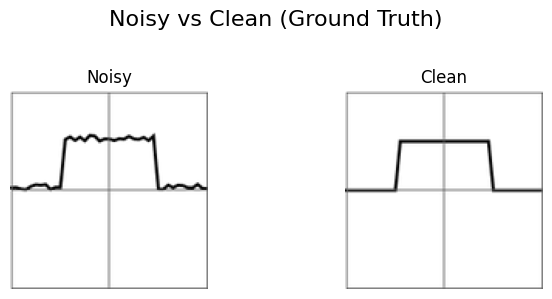

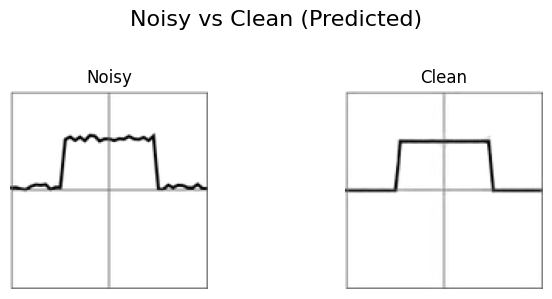

In [17]:
# Взять один батч из валидационного датасета
for noisy_images, clean_images in val_dataset.take(20):
    # Предсказание модели
    predicted_images = model.predict(noisy_images)
    
    # Отображение
    print("Визуализация предсказаний:")
    display_noisy_clean_grid(noisy_images, clean_images, title="Noisy vs Clean (Ground Truth)")
    display_noisy_clean_grid(noisy_images, predicted_images, title="Noisy vs Clean (Predicted)")


In [18]:
import numpy as np

# Взять один батч из валидационного датасета
for noisy_images, clean_images in val_dataset.take(1):
    predicted_images = model.predict(noisy_images)
    
    # Вычислить MSE и MAE
    mse = np.mean((predicted_images - clean_images.numpy())**2)
    mae = np.mean(np.abs(predicted_images - clean_images.numpy()))
    print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
    print(f"Средняя абсолютная ошибка (MAE): {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Среднеквадратичная ошибка (MSE): 0.0002
Средняя абсолютная ошибка (MAE): 0.0045


2024-11-19 18:10:41.215907: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


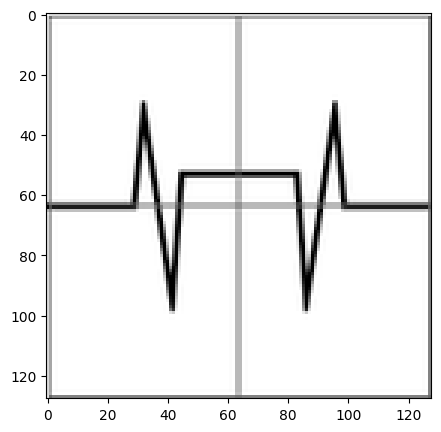

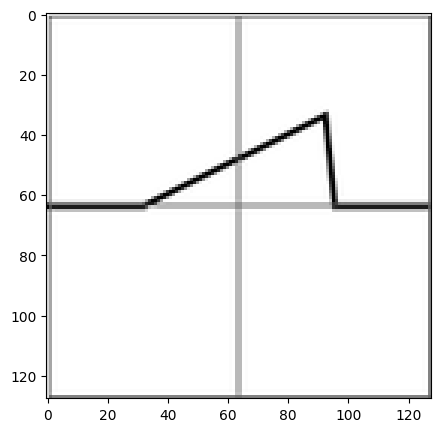

In [19]:
for noisy_images, clean_images in val_dataset.take(2):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    image = clean_images
    axes.imshow(image.numpy().squeeze(), cmap='gray')

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_image(model, image_path, image_size=(128, 128)):
    """
    Прогоняет изображение через модель для получения предсказания.
    
    Аргументы:
    - model: обученная модель.
    - image_path: путь к изображению.
    - image_size: размер, до которого изображение будет приведено (по умолчанию 128x128).
    
    Вывод:
    - Отображает оригинальное изображение, зашумленное и предсказанное изображение.
    """
    # Шаг 1: Загрузка изображения
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Градации серого
    image = tf.image.resize(image, IMG_SIZE)  # Изменение размера
    image = tf.cast(image, tf.float32) / 255.0  # Нормализация в диапазон [0, 1]
    
    # Добавляем дополнительную ось для батча (нужно для модели)
    noisy_image = tf.expand_dims(image, axis=0)

    # Шаг 2: Прогоняем через модель
    predicted_image = model.predict(noisy_image)

    # Шаг 3: Отображение изображений
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Check predictions NW", fontsize=16)

    # Оригинальное изображение (чистое)
    axes[0].imshow(image.numpy().squeeze(), cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Зашумленное изображение
    axes[1].imshow(noisy_image.numpy().squeeze(), cmap='gray')
    axes[1].set_title("NW's img")
    axes[1].axis("off")

    # Предсказанное изображение
    axes[2].imshow(predicted_image.squeeze(), cmap='gray')
    axes[2].set_title("Predicted")
    axes[2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


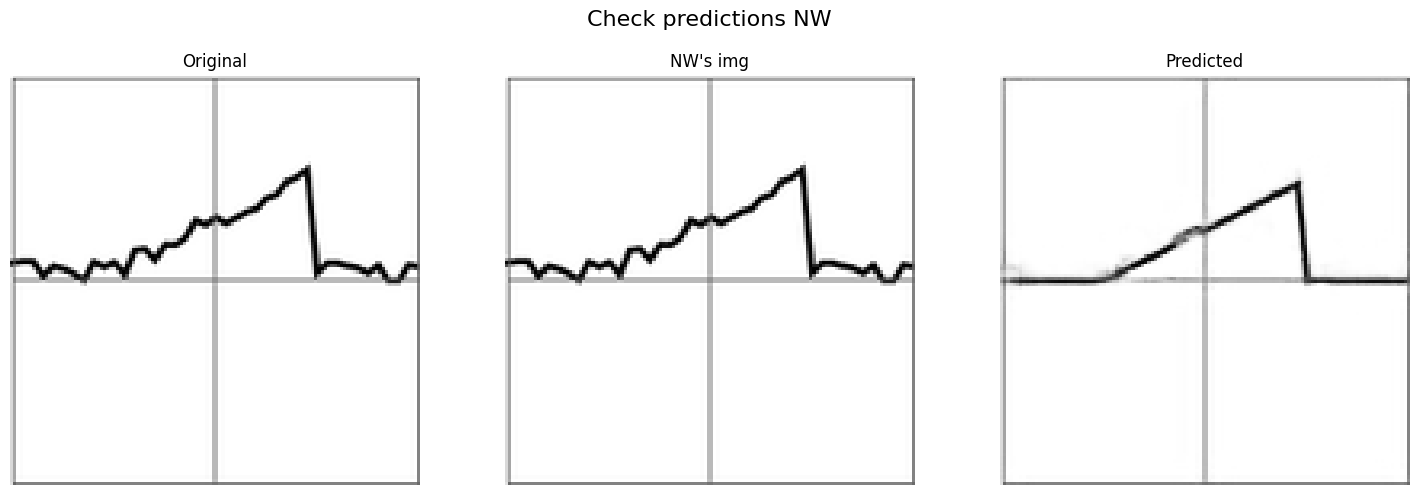

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


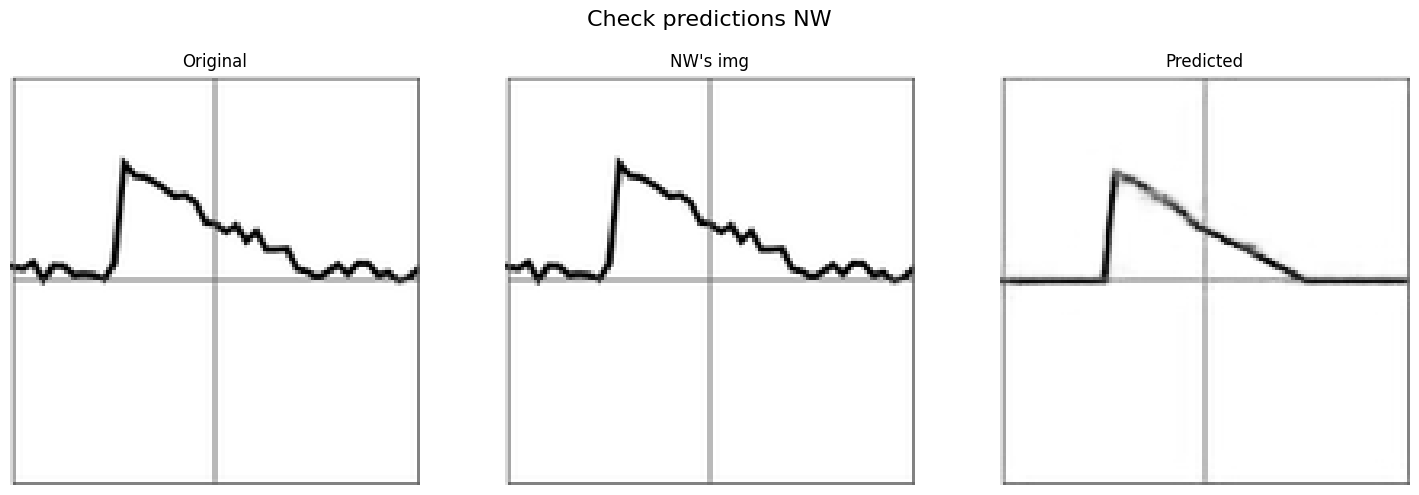

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


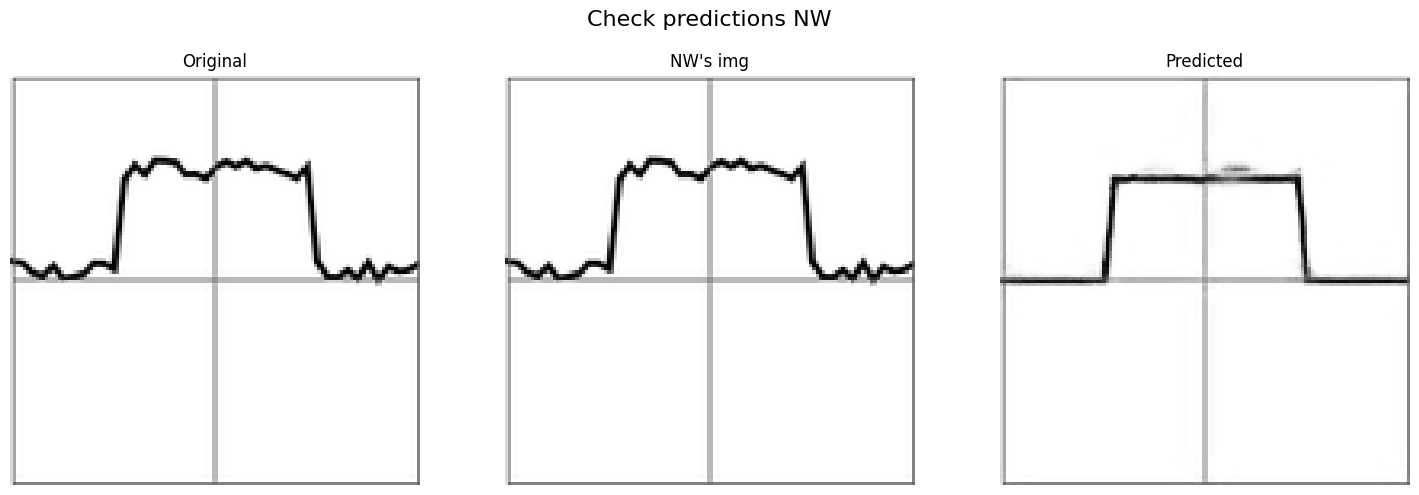

In [21]:
# Пример использования
image_path1 = "/home/gercklim/WORK_DIRECTORY/7_СЕМ/Курсовая_работа_7_сем/NW_for_Transfer_Equation/DATASETS/DATASET_1/fig1/0.png"  # Путь к изображению
image_path2 = "/home/gercklim/WORK_DIRECTORY/7_СЕМ/Курсовая_работа_7_сем/NW_for_Transfer_Equation/DATASETS/DATASET_1/fig2/0.png"
image_path3 = "/home/gercklim/WORK_DIRECTORY/7_СЕМ/Курсовая_работа_7_сем/NW_for_Transfer_Equation/DATASETS/DATASET_1/fig3/0.png"
predict_image(model, image_path1)
predict_image(model, image_path2)
predict_image(model, image_path3)